In [1]:
# Decision Tree to classify movie addicts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
class Node:
    def __init__(self, column, col_index, gini_score, callback):
        self.column = column
        self.col_index = col_index
        self.left = None
        self.right = None
        self.gini = gini_score
        self.apply = callback
        
class DecisionTree:
    def __init__(self, X, y):
        # Change columns into index
        X.columns = np.arange(0, X.columns.shape[0])
        self.original_X = X
        self.X = X
        self.y = y
        self.root = None
        self.current = self.root
        self.classes = np.unique(y)
        self.build_tree()
    
    def build_tree(self):
        self.select_root()
        self.build_children_nodes()
    
    def select_root(self):
        # Method to select the root
        # The root is the node of a column which has
        # the minimum gini score
        
        nodes = np.array([], dtype=Node)
        gini_scores = np.empty((self.X.columns.shape[0],))
        
        # Try to convert each column to a node
        for i,j in zip(self.X.columns, range(self.X.columns.shape[0])):
            column = self.X.iloc[:, i]
            node = self.column_to_node(column, i)
            gini_score = node.gini
            gini_scores[j] = gini_score
            nodes = np.append(nodes, node)
            
        # Select the node with the minimum gini score as the root
        self.root = nodes[np.argmin(gini_scores)]
        self.current = self.root
        
        # Drop the column which represents the root
        self.X = self.X.drop(self.root.col_index, axis=1)
    
    def find_next_node(self, previous_node):
        # Method to find the best column to represent
        # the next node
        gini_scores = np.empty((self.X.columns.shape[0],))
        nodes = np.empty((gini_scores.shape[0],), dtype=Node)
        
        # Try to convert every available column to a node
        # and select the one with the minimum gini score
        for i,j in zip(self.X.columns, range(self.X.columns.shape[0])):
            column = self.X.loc[self.original_X.iloc[:,previous_node.col_index].apply(previous_node.apply),i]
            node = self.column_to_node(column, i)
            gini_scores[j] = node.gini
            nodes[j] = node
        
        # Select the node with the minimim gini score
        candidate_node = nodes[np.argmin(gini_scores)]
        
        # Drop the column which represents the selected node
        self.X = self.X.drop(candidate_node.col_index, axis=1)
        return candidate_node
        
    def build_children_nodes(self):
        # Convert columns to nodes, append them to the tree
        
        # If gini score is > 0, the node can produce children
        # otherwise, if gini score is 0, it means that the node
        # is sufficient to classify all the samples
        # with 100% accuracy
        if(self.current.gini > 0):
            # Try to create two nodes (left & right) for the current
            current_node_left = self.column_to_node(self.current.column[self.current.column.apply(self.current.apply)], self.current.col_index)
            current_node_right = self.column_to_node(self.current.column[~self.current.column.apply(self.current.apply)], self.current.col_index)
            
            # if the left node can be splitted, find its children
            if(current_node_left.gini > 0):
                self.current.left = self.find_next_node(self.current)
                self.current = self.current.left
                self.build_children_nodes()
            
            # if the right node can be splitted, find its children
            if(current_node_right.gini > 0):
                self.current.right = self.find_next_node(self.current)
                self.current = self.current.right
                self.build_children_nodes()
        
    def calculate_gini(self, classes_counted):
        
        # Keep the gini score of each class
        classes_gini = pd.Series(index=classes_counted.index)
        # calculate the weight of each class
        classes_weights = classes_counted.sum(axis=1) / classes_counted.sum().sum()
        
        # Calculate gini score for each class
        for index in classes_counted.columns:
            x = (classes_counted.iloc[index] / classes_counted.iloc[index].sum()) ** 2
            gini = np.concatenate(([1], x[0:]*-1)).sum()
            classes_gini[index] = gini
        total_gini = (classes_weights * classes_gini).sum()
        return total_gini
    
    def column_to_node(self, column, col_index):
        # Method to convert a column into a node
        
        # Find unique values of a column
        unique_values = np.unique(column)
        
        # if column has binary data
        if unique_values.shape[0] == 2:
            counts_classified = np.array([])
            
            # Count classes for each value of the column
            for _class in self.classes:
                column_count_0 = self.y[(column == unique_values[0]) & (self.y == _class)].count()
                column_count_1 = self.y[(column == unique_values[1]) & (self.y == _class)].count()
                counts = pd.Series(index=[0,1], data=np.array([
                    column_count_0, column_count_1
                ]))
                counts_classified = np.append(counts_classified, counts)
            
            # Create a container of counts to calculate gini score
            counts_classified = counts_classified.reshape((-1,self.classes.shape[0]))[:,:].T
            classes_counted = pd.DataFrame(index=self.classes, data=counts_classified)
            gini = self.calculate_gini(classes_counted)
            
            # Create node
            node = Node(column, col_index, gini, lambda x: x == 1)
        
        # Otherwise, the column has many (+2) distinct values
        else:
            # Calculate the average of every two consecutive values
            sorted_column = column.sort_values()
            consecutive_means = np.mean(list(zip(sorted_column[:], sorted_column[1:])), axis=1)
            gini_scores = np.array([])
            
            # For every mean, count the classes of
            # every value (in the column) less than the mean
            # and the same for values >= mean
            for mean in consecutive_means:
                counts_classified = np.array([])
                for _class in self.classes:
                    column_count_lt = self.y[(column < mean) & (self.y == _class)].count()
                    column_count_gte = self.y[(column >= mean) & (self.y == _class)].count()
                    counts = pd.Series(index=[1,0], data=np.array([
                        column_count_lt, column_count_gte
                    ]))
                    counts_classified = np.append(counts_classified, counts)
                    
                # Calculate the gini score of the collected counts
                counts_classified = counts_classified.reshape((-1,self.classes.shape[0]))[:,:][::-1].T
                classes_counted = pd.DataFrame(index=self.classes[::-1], data=counts_classified)
                gini = self.calculate_gini(classes_counted.sort_index())
                gini_scores = np.append(gini_scores, gini)
            
            # Select the mean with the minimum gini score and
            # create a node using the column and a callback which
            # depends on the mean
            min_gini_index = np.argmin(gini_scores)
            min_gini_score = gini_scores[min_gini_index]
            best_mean = consecutive_means[min_gini_index]
            node = Node(column, col_index, min_gini_score, lambda x: x < best_mean)
        return node
    
    def predict(self, sample):
        current = self.root
        next_node = self.root
        
        # Traverse the tree until a leaf node is reached
        while next_node is not None:
            current = next_node
            is_left_direction = current.apply(sample[current.col_index])
            if is_left_direction:
                next_node = current.left
            else:
                next_node = current.right
                
        # Apply the node callback on the sample
        # and check if the return is True or False
        is_left_leaf = current.apply(sample[current.col_index])
        if is_left_leaf:
            # Make a vote using classes which apply to the node condition
            applicable_indexes = current.column[current.column.apply(current.apply)].index
        else:
            # Make a vote using classes which does NOT apply to the node condition
            applicable_indexes = current.column[~current.column.apply(current.apply)].index
        
        # Return the class with the highest vote
        return self.y[applicable_indexes].value_counts().idxmax()

In [4]:
# Read data
data = pd.read_csv("../input/movie-addicts/movie_addicts.csv")
data.head(data.shape[0])

,loves_popcorn,loves_soda,age,movie_addiction
0,1,1,7,0
1,1,0,12,0
2,0,1,18,1
3,0,1,35,1
4,1,1,38,1
5,1,1,40,1
6,0,1,47,1
7,1,0,50,0
8,0,0,60,0
9,0,0,70,0


In [5]:
# Build the decision tree

X = data.iloc[:,:3]
y = data.iloc[:,3]
tree = DecisionTree(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Text(0.5, 1.0, 'Tree Visualization')

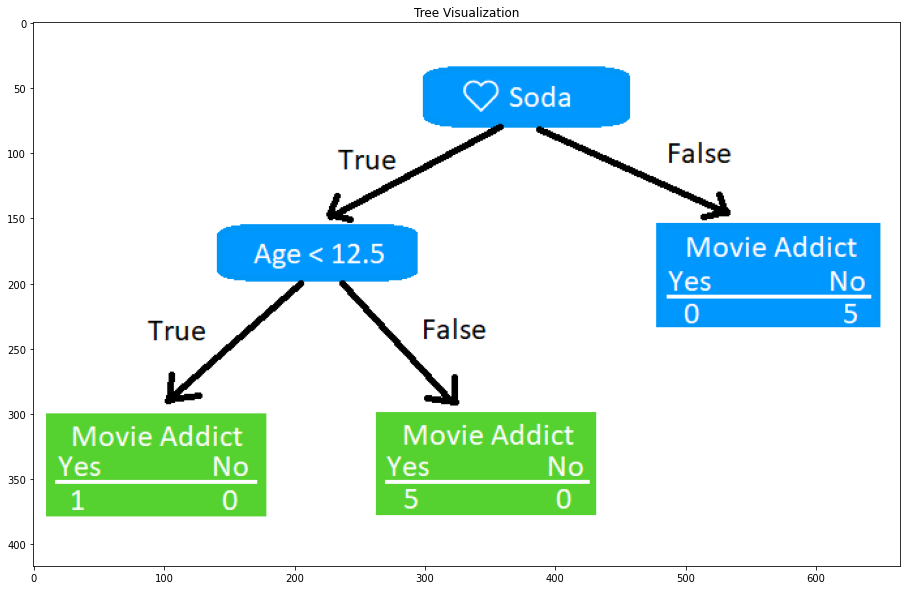

In [6]:
# Visualization of the tree
tree_visual = plt.imread("../input/movie-addicts/movie_addicts_tree.png")
plt.figure(figsize = (20,10))
plt.imshow(tree_visual)
plt.title("Tree Visualization")

In [7]:
# Training-set prediction & Accuracy measuring

y_pred = np.array([])
for row in X.values:
    prediction = tree.predict(row)
    y_pred = np.append(y_pred, prediction)

training_accuracy = (np.count_nonzero(y_pred == y) / X.shape[0]) * 100
print(f"Training Accuracy = {training_accuracy}%")

Training Accuracy = 100.0%


Text(0, 0.5, 'Age')

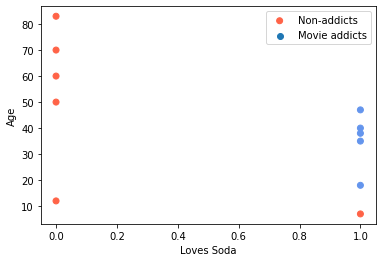

In [8]:
# Data Visualization

# As to the figure (tree visualization)
# only the (Soda, Age) columns have the
# effect on the classification result
colors = np.array(['tomato','cornflowerblue'])
plt.scatter(X.iloc[:,1], X.iloc[:,2], c=colors[y])
plt.scatter(None,None)
plt.legend(["Non-addicts", "Movie addicts"])
plt.xlabel("Loves Soda")
plt.ylabel("Age")